### Import and register model

In [1]:
from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.policy.policy_map import PolicyMap
from ray.rllib.evaluation.episode import Episode
from ray.rllib.models.catalog import ModelCatalog
import numpy as np

from parameters import parameters

ModelCatalog.register_custom_model("model", parameters["model"])

In [2]:
checkpoint_path = "exps/AlphaZero_TicTacToe/contrib_AlphaZero_TicTacToe_8aae7_00000_0_2022-05-11_07-52-31/checkpoint_000040/checkpoint-40"

### Evaluation parameters

In [3]:
parameters["config"]["mcts_config"]["num_simulations"] = 1000
parameters["config"]["mcts_config"]["argmax_tree_policy"] = True
parameters["config"]["mcts_config"]["add_dirichlet_noise"] = False
parameters["config"]["mcts_config"]["temperature"] = 1

### Load the agent

In [4]:
agent = AlphaZeroTrainer(env=parameters["env"], config=parameters["config"])
agent.restore(checkpoint_path)
policy = agent.get_policy()

env = parameters["env"]()

2022-05-25 18:02:46,779	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=111198) 2022-05-25 18:02:51,777	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=111198) 2022-05-25 18:02:51,777	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=111200) 2022-05-25 18:02:51,733	WARNING rollout_worker.py:498 

### Test the agent

- If `use_model_only` is `True`, the actions are chosen using only the policy network
- If `vs_human` is `True`, you can play vs the agent by entering a valid action

In [5]:
use_model_only = False
vs_human = False

6


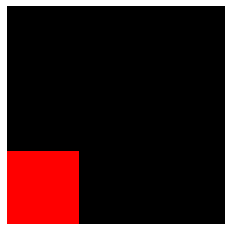

4


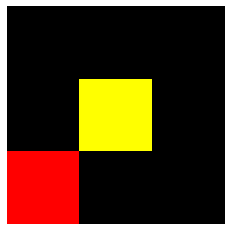

3


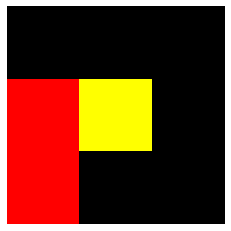

0


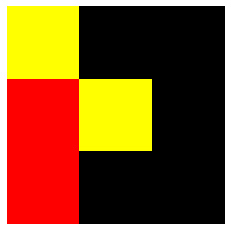

8


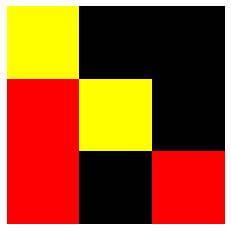

7


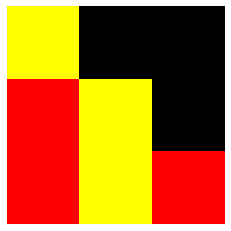

1


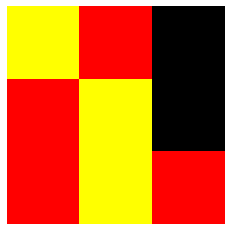

5


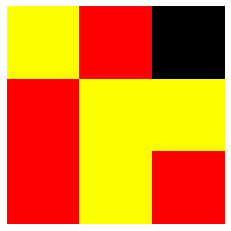

2


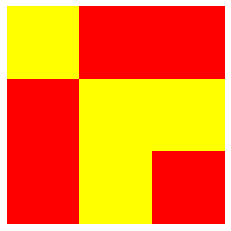

In [6]:
episode = Episode(
    PolicyMap(0,0),
    lambda _, __: DEFAULT_POLICY_ID,
    lambda: None,
    lambda _: None,
    0,
)

obs = env.reset()

count = 0
done = False
while not done:
  episode.user_data['initial_state'] = env.get_state()
  if count % 2 == 0 or not vs_human:
    if use_model_only:
      obs["obs"] = torch.from_numpy(obs["obs"]).float()
      valid_action = obs["action_mask"].astype(bool)
      action = policy.model.forward(obs, None, None)[0]
      action[~valid_action] = -np.inf
      action = torch.argmax(action).item()
    else:
      action, _, _ = policy.compute_single_action(obs, episode=episode)
  else:
    action = int(input("Type a valid action:"))
  print(action)
  obs, reward, done, _ = env.step(action)
  env.render()
  count += 1

### Test the policy network

In [7]:
import torch

obs = env.reset()
obs, _, _, _ = env.step(0)
obs["obs"] = torch.from_numpy(obs["obs"]).float()

policy.model.forward(obs, None, None)[0], policy.model.value_function()

(tensor([-0.5177,  0.0590,  0.1155, -0.0305,  1.4863, -0.3414,  0.1150, -0.5277,
         -0.5194], grad_fn=<AddBackward0>),
 tensor([-0.0290], grad_fn=<AddBackward0>))